In [1]:
import os 
import pandas as pd 
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms


Load the Data


In [2]:
benign ='data/archive/Dataset_BUSI_with_GT/benign'
malignant='data/archive/Dataset_BUSI_with_GT/malignant'
normal='data/archive/Dataset_BUSI_with_GT/normal'

In [3]:
count_benign=len(os.listdir(benign))
count_malignant=len(os.listdir(malignant))
count_normal=len(os.listdir(normal))

print(count_benign)
print(count_malignant)
print(count_normal)

#Data is clearly not balanced

891
421
266


Look at the data

In [4]:
def create_data(data_dir, categories):
    images = []
    masks = []
    labels = []

    for i, category in enumerate(categories):
        category_dir = os.path.join(data_dir, category)
        for file_name in os.listdir(category_dir):
            if "_mask" in file_name:
                continue
            image_file_path = os.path.join(category_dir, file_name)
            mask_file_name = file_name.replace(".", "_mask.")
            mask_file_path = os.path.join(category_dir, mask_file_name)
            if not os.path.exists(mask_file_path):
                continue


            images.append(image_file_path)
            masks.append(mask_file_path)
            labels.append(category)

            if category == 'malignant' or category == 'normal':
                images.append(image_file_path)
                masks.append(mask_file_path)
                labels.append(category)

            if category == 'normal':
                images.append(image_file_path)
                masks.append(mask_file_path)
                labels.append(category)

            

    print(f"Found {len(images)} image/mask pairs in {len(categories)} categories")
    return images, masks, labels

In [5]:
data_dir ="data/archive/Dataset_BUSI_with_GT"

categories = ['normal','benign','malignant']

images,masks,labels=create_data(data_dir,categories)

id = [i for i in range(len(images))]

normal_labels = []
benign_labels = []
malignant_labels = []

for label in labels:
    normal_labels.append(float(1) if label=="normal" else float(0))
    benign_labels.append(float(1) if label=="benign" else float(0))
    malignant_labels.append(float(1)if label=="malignant" else float(0))



Found 1256 image/mask pairs in 3 categories


In [6]:

images_df = pd.DataFrame({ "image":images})
#images_df.set_index('id')

labels_df = pd.DataFrame({ "normal": normal_labels, "benign":benign_labels, "malignant": malignant_labels},)
#labels_df.set_index('id')


In [7]:
images_df

,image
0,data/archive/Dataset_BUSI_with_GT\normal\norma...
1,data/archive/Dataset_BUSI_with_GT\normal\norma...
2,data/archive/Dataset_BUSI_with_GT\normal\norma...
3,data/archive/Dataset_BUSI_with_GT\normal\norma...
4,data/archive/Dataset_BUSI_with_GT\normal\norma...
...,...
1251,data/archive/Dataset_BUSI_with_GT\malignant\ma...
1252,data/archive/Dataset_BUSI_with_GT\malignant\ma...
1253,data/archive/Dataset_BUSI_with_GT\malignant\ma...
1254,data/archive/Dataset_BUSI_with_GT\malignant\ma...


In [7]:
from sklearn.model_selection import train_test_split

random_sample = 15

y = labels_df.sample(frac=1, random_state = random_sample)
display(y)
x = images_df.loc[y.index].image.to_frame()

# note that we are casting the species labels to an indicator/dummy matrix
x_train, x_eval, y_train, y_eval = train_test_split(
    x, y, stratify=y, test_size=0.25, random_state=random_sample
)

,normal,benign,malignant
759,0.0,1.0,0.0
334,1.0,0.0,0.0
148,1.0,0.0,0.0
1091,0.0,0.0,1.0
194,1.0,0.0,0.0
...,...,...,...
1223,0.0,0.0,1.0
667,0.0,1.0,0.0
156,1.0,0.0,0.0
384,1.0,0.0,0.0


In [8]:
x_train

,image
279,data/archive/Dataset_BUSI_with_GT\benign\benig...
89,data/archive/Dataset_BUSI_with_GT\benign\benig...
539,data/archive/Dataset_BUSI_with_GT\malignant\ma...
300,data/archive/Dataset_BUSI_with_GT\benign\benig...
339,data/archive/Dataset_BUSI_with_GT\benign\benig...
...,...
382,data/archive/Dataset_BUSI_with_GT\benign\benig...
631,data/archive/Dataset_BUSI_with_GT\malignant\ma...
389,data/archive/Dataset_BUSI_with_GT\benign\benig...
251,data/archive/Dataset_BUSI_with_GT\benign\benig...


In [9]:
y_eval

,normal,benign,malignant
364,0.0,1.0,0.0
340,0.0,1.0,0.0
554,0.0,0.0,1.0
110,0.0,1.0,0.0
243,0.0,1.0,0.0
...,...,...,...
221,0.0,1.0,0.0
103,0.0,1.0,0.0
248,0.0,1.0,0.0
443,0.0,0.0,1.0


In [8]:
split_pcts = pd.DataFrame(
    {
        "train": y_train.idxmax(axis=1).value_counts(normalize=True),
        "eval": y_eval.idxmax(axis=1).value_counts(normalize=True),
    }
)
print("Species percentages by split")
(split_pcts.fillna(0) * 100).astype(int)

Species percentages by split


,train,eval
benign,34,34
malignant,33,33
normal,31,31


In [9]:

# Use CUDA
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random

def plot_data(X,Y,label):
  
  index = Y[(Y[label] == 1)].sample(1).index[0]
  row = X.loc[index]
  
  img = cv2.imread(row['image'])

  fig, axs = plt.subplots(1, 2, figsize=(15, 5))
  axs[0].imshow(img)
  axs[0].set_title('Image')
  axs[1].text(0.5, 0.5, f'ID: {index}\nLabel: {label}', ha='center', va='center', fontsize=16)
  axs[1].axis('off')
  plt.show()

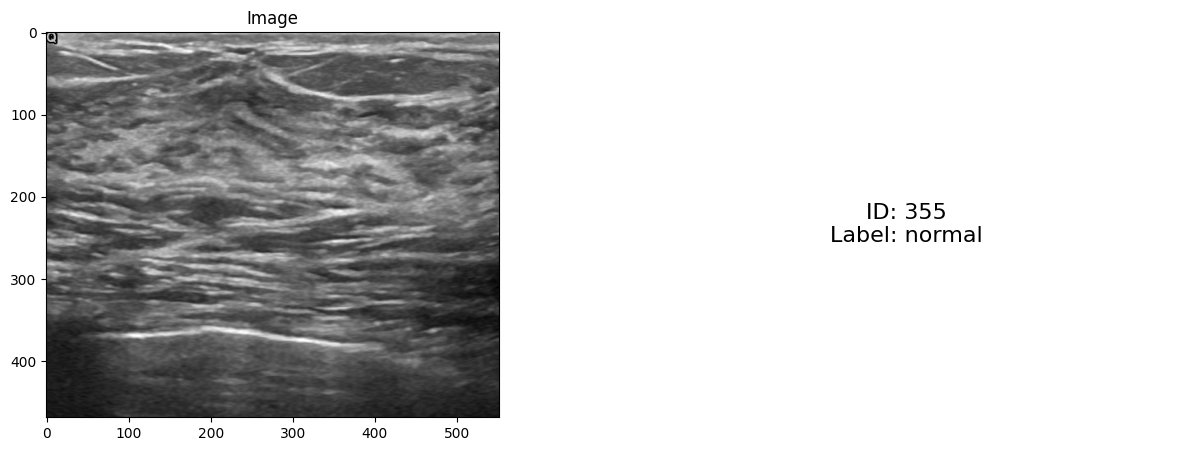

In [11]:
plot_data(x_train,y_train,"normal")

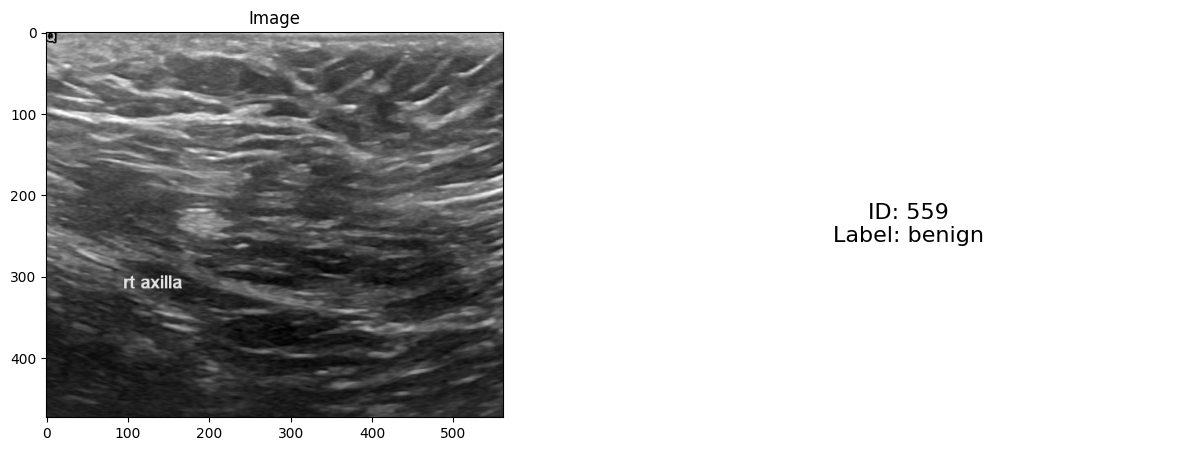

In [12]:
plot_data(x_train,y_train,"benign")

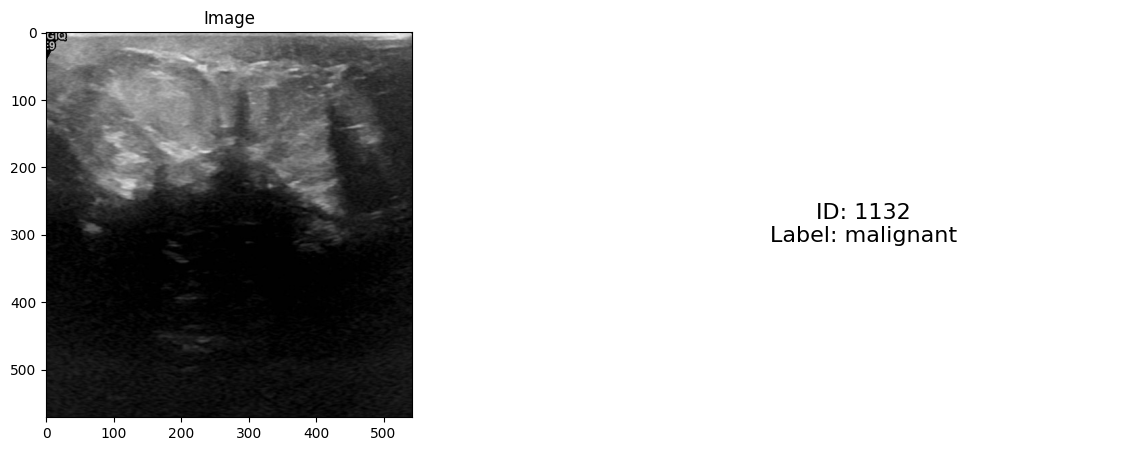

In [13]:
plot_data(x_train,y_train,"malignant")

In [14]:


class ImagesDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_df, y_df=None, eval = False):
        self.data = x_df
        self.label = y_df

        if eval == False:
            print("Training Mode")
            self.transform = transforms.Compose(
                [
                    transforms.Resize((224, 224)),
                    transforms.RandomPerspective(distortion_scale = 0.3, p = 0.5),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                    ),
                ])

        if eval == True:
            print("Evaluation Mode")
            self.transform = transforms.Compose(
                [
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                    ),
                ])

    def __getitem__(self, index):
        image = Image.open(self.data.iloc[index]["image"]).convert("RGB")
        image = self.transform(image)
        image_id = self.data.index[index]
        # if we don't have labels (e.g. for test set) just return the image and image id
        if self.label is None:
            sample = {"image": image}
        else:
            label = torch.tensor(self.label.iloc[index], 
                                 dtype=torch.float)
            sample = {"image": image, "label": label}
        return sample

    def __len__(self):
        return len(self.data)

In [34]:
# from torch import nn
# import torchvision.models as models

# model = models.resnet152(pretrained = True)

# model.fc = nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(2048, 100),  # dense layer takes a 2048-dim input and outputs 100-dim
#     nn.ReLU(inplace=True),  # ReLU activation introduces non-linearity
#     nn.Dropout(0.1),  # common technique to mitigate overfitting
#     nn.Linear(
#         100, 3
#     ),  # final dense layer outputs 8-dim corresponding to our target classes
# )

# The code is creating a ResNet152V2 model with pre-trained weights from the ImageNet dataset. 
# The base model is frozen, meaning its weights will not be updated during training. 
# The code then appends additional layers on top of the base model for transfer learning.

from tensorflow.keras.applications import resnet_v2

IMAGE_SHAPE = (224, 224)


base_model = resnet_v2.ResNet152V2(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMAGE_SHAPE, 3),
    classes=3)

# Freeze the base_model
base_model.trainable = False

# append my own layers on the top of the model for Transfer Learning
x = base_model.output

# 1st conv block
x = layers.Conv2D(256, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 2nd conv block
x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 1st FC layer
x = layers.Flatten()(x) 
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# 2nd FC layer
x = layers.Dense(32, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(.2)(x)

x = layers.Dense(3, 'softmax')(x)

incept_model = keras.models.Model(inputs = base_model.input, outputs = x)

# compile the model
incept_model.compile(optimizer=optimizers.RMSprop(.001), loss = losses.sparse_categorical_crossentropy, metrics= [metrics.SparseCategoricalAccuracy()])

# incept_model.summary()

234545216/234545216 [==============================] - 154s 1us/step


NameError: name 'layers' is not defined

In [16]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

In [17]:
# Send model to GPU
# Send the model to GPU
model = model.to(DEVICE)

In [18]:

num_epochs = 30

tracking_loss = {}


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.0001, total_iters=num_epochs)


for epoch in range(1, num_epochs + 1):
    print(f"Starting epoch {epoch}")
    loss_array = []
    
    train_dataset = ImagesDataset(x_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=8)

    # iterate through the dataloader batches. tqdm keeps track of progress.
    for batch_n, batch in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):
        
        # 1) zero out the parameter gradients so that gradients from previous batches are not used in this step
        optimizer.zero_grad()

        # 2) run the forward step on this batch of images
        outputs = model(batch["image"].to(DEVICE))

        # 3) compute the loss
        loss = criterion(outputs, batch["label"].to(DEVICE))
        loss_array.append(float(loss))

        # let's keep track of the loss by epoch and batch
        tracking_loss[(epoch, batch_n)] = float(loss)

        # 4) compute our gradients
        loss.backward()
        # update our weights
        optimizer.step()

    print(f"The average loss: {round( (sum(loss_array)/len(loss_array)),5)}")

Starting epoch 1
Training Mode


100%|██████████| 118/118 [00:23<00:00,  4.96it/s]


The average loss: 1.02775
Starting epoch 2
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.57it/s]


The average loss: 0.64835
Starting epoch 3
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.56it/s]


The average loss: 0.40381
Starting epoch 4
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.51it/s]


The average loss: 0.31935
Starting epoch 5
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.52it/s]


The average loss: 0.22881
Starting epoch 6
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.52it/s]


The average loss: 0.18585
Starting epoch 7
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.54it/s]


The average loss: 0.14504
Starting epoch 8
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.47it/s]


The average loss: 0.1169
Starting epoch 9
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.47it/s]


The average loss: 0.09
Starting epoch 10
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.42it/s]


The average loss: 0.07374
Starting epoch 11
Training Mode


100%|██████████| 118/118 [00:20<00:00,  5.81it/s]


The average loss: 0.08742
Starting epoch 12
Training Mode


100%|██████████| 118/118 [00:20<00:00,  5.78it/s]


The average loss: 0.08115
Starting epoch 13
Training Mode


100%|██████████| 118/118 [00:20<00:00,  5.76it/s]


The average loss: 0.04822
Starting epoch 14
Training Mode


100%|██████████| 118/118 [00:20<00:00,  5.78it/s]


The average loss: 0.04545
Starting epoch 15
Training Mode


100%|██████████| 118/118 [00:20<00:00,  5.74it/s]


The average loss: 0.03594
Starting epoch 16
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.51it/s]


The average loss: 0.0279
Starting epoch 17
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.48it/s]


The average loss: 0.04481
Starting epoch 18
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.47it/s]


The average loss: 0.03465
Starting epoch 19
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.45it/s]


The average loss: 0.03373
Starting epoch 20
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.43it/s]


The average loss: 0.03088
Starting epoch 21
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.46it/s]


The average loss: 0.02575
Starting epoch 22
Training Mode


100%|██████████| 118/118 [00:22<00:00,  5.32it/s]


The average loss: 0.01797
Starting epoch 23
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.39it/s]


The average loss: 0.00989
Starting epoch 24
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.46it/s]


The average loss: 0.00583
Starting epoch 25
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.48it/s]


The average loss: 0.00416
Starting epoch 26
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.49it/s]


The average loss: 0.00394
Starting epoch 27
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.50it/s]


The average loss: 0.00387
Starting epoch 28
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.48it/s]


The average loss: 0.00227
Starting epoch 29
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.48it/s]


The average loss: 0.00258
Starting epoch 30
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.49it/s]


The average loss: 0.00595
Starting epoch 31
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.44it/s]


The average loss: 0.00249
Starting epoch 32
Training Mode


100%|██████████| 118/118 [00:22<00:00,  5.34it/s]


The average loss: 0.00161
Starting epoch 33
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.47it/s]


The average loss: 0.0013
Starting epoch 34
Training Mode


100%|██████████| 118/118 [00:24<00:00,  4.78it/s]


The average loss: 0.00251
Starting epoch 35
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.37it/s]


The average loss: 0.00181
Starting epoch 36
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.47it/s]


The average loss: 0.00344
Starting epoch 37
Training Mode


100%|██████████| 118/118 [00:22<00:00,  5.28it/s]


The average loss: 0.004
Starting epoch 38
Training Mode


100%|██████████| 118/118 [00:22<00:00,  5.36it/s]


The average loss: 0.00203
Starting epoch 39
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.51it/s]


The average loss: 0.00122
Starting epoch 40
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.45it/s]


The average loss: 0.0014
Starting epoch 41
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.42it/s]


The average loss: 0.00363
Starting epoch 42
Training Mode


100%|██████████| 118/118 [00:20<00:00,  5.63it/s]


The average loss: 0.00094
Starting epoch 43
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.58it/s]


The average loss: 0.00148
Starting epoch 44
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.40it/s]


The average loss: 0.00161
Starting epoch 45
Training Mode


100%|██████████| 118/118 [00:22<00:00,  5.32it/s]


The average loss: 0.00083
Starting epoch 46
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.38it/s]


The average loss: 0.00068
Starting epoch 47
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.48it/s]


The average loss: 0.0006
Starting epoch 48
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.46it/s]


The average loss: 0.00303
Starting epoch 49
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.47it/s]


The average loss: 0.0007
Starting epoch 50
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.47it/s]


The average loss: 0.00041
Starting epoch 51
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.44it/s]


The average loss: 0.00079
Starting epoch 52
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.45it/s]


The average loss: 0.00039
Starting epoch 53
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.59it/s]


The average loss: 0.00041
Starting epoch 54
Training Mode


100%|██████████| 118/118 [00:20<00:00,  5.69it/s]


The average loss: 0.00044
Starting epoch 55
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.52it/s]


The average loss: 0.00079
Starting epoch 56
Training Mode


100%|██████████| 118/118 [00:23<00:00,  4.93it/s]


The average loss: 0.00053
Starting epoch 57
Training Mode


100%|██████████| 118/118 [00:22<00:00,  5.29it/s]


The average loss: 0.00069
Starting epoch 58
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.46it/s]


The average loss: 0.00047
Starting epoch 59
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.46it/s]


The average loss: 0.00185
Starting epoch 60
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.49it/s]


The average loss: 0.00146
Starting epoch 61
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.44it/s]


The average loss: 0.0023
Starting epoch 62
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.46it/s]


The average loss: 0.00158
Starting epoch 63
Training Mode


100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


The average loss: 0.00072
Starting epoch 64
Training Mode


100%|██████████| 118/118 [00:22<00:00,  5.22it/s]


The average loss: 0.00142
Starting epoch 65
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.50it/s]


The average loss: 0.00107
Starting epoch 66
Training Mode


100%|██████████| 118/118 [00:20<00:00,  5.76it/s]


The average loss: 0.00093
Starting epoch 67
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.54it/s]


The average loss: 0.00034
Starting epoch 68
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.39it/s]


The average loss: 0.00047
Starting epoch 69
Training Mode


100%|██████████| 118/118 [00:22<00:00,  5.32it/s]


The average loss: 0.00043
Starting epoch 70
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.47it/s]


The average loss: 0.00052
Starting epoch 71
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.48it/s]


The average loss: 0.00023
Starting epoch 72
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.48it/s]


The average loss: 0.00052
Starting epoch 73
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.47it/s]


The average loss: 0.00033
Starting epoch 74
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.48it/s]


The average loss: 0.00049
Starting epoch 75
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.48it/s]


The average loss: 0.00033
Starting epoch 76
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.48it/s]


The average loss: 0.0005
Starting epoch 77
Training Mode


100%|██████████| 118/118 [00:22<00:00,  5.23it/s]


The average loss: 0.00026
Starting epoch 78
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.42it/s]


The average loss: 0.00025
Starting epoch 79
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.47it/s]


The average loss: 0.00029
Starting epoch 80
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.45it/s]


The average loss: 0.00021
Starting epoch 81
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.44it/s]


The average loss: 0.00018
Starting epoch 82
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.46it/s]


The average loss: 0.00025
Starting epoch 83
Training Mode


100%|██████████| 118/118 [00:22<00:00,  5.27it/s]


The average loss: 0.00012
Starting epoch 84
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.37it/s]


The average loss: 0.00022
Starting epoch 85
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.45it/s]


The average loss: 0.00026
Starting epoch 86
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.41it/s]


The average loss: 0.0002
Starting epoch 87
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.44it/s]


The average loss: 0.00016
Starting epoch 88
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.46it/s]


The average loss: 0.00016
Starting epoch 89
Training Mode


100%|██████████| 118/118 [00:22<00:00,  5.34it/s]


The average loss: 0.00011
Starting epoch 90
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.44it/s]


The average loss: 0.00015
Starting epoch 91
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.47it/s]


The average loss: 0.00015
Starting epoch 92
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.47it/s]


The average loss: 0.0001
Starting epoch 93
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.48it/s]


The average loss: 0.00021
Starting epoch 94
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.46it/s]


The average loss: 0.00015
Starting epoch 95
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.41it/s]


The average loss: 0.00015
Starting epoch 96
Training Mode


100%|██████████| 118/118 [00:22<00:00,  5.35it/s]


The average loss: 0.00017
Starting epoch 97
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.46it/s]


The average loss: 9e-05
Starting epoch 98
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.49it/s]


The average loss: 0.00018
Starting epoch 99
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.46it/s]


The average loss: 0.00018
Starting epoch 100
Training Mode


100%|██████████| 118/118 [00:21<00:00,  5.46it/s]

The average loss: 0.00011


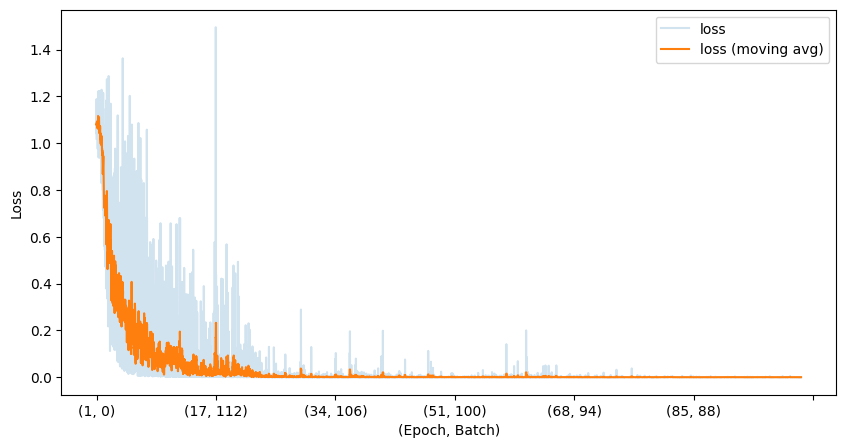

In [19]:
tracking_loss = pd.Series(tracking_loss)

plt.figure(figsize=(10, 5))
tracking_loss.plot(alpha=0.2, label="loss")
tracking_loss.rolling(center=True, min_periods=1, window=10).mean().plot(
    label="loss (moving avg)"
)
plt.xlabel("(Epoch, Batch)")
plt.ylabel("Loss")
plt.legend(loc=0)

In [20]:
torch.save(model, "model.pth")

In [21]:
loaded_model = torch.load("model.pth")

In [22]:
eval_dataset = ImagesDataset(x_eval, y_eval, eval = True)
eval_dataloader = DataLoader(eval_dataset, batch_size=1)

Evaluation Mode


In [23]:
actual_value = []
predicted_value = []

model = model.to("cpu")

for i in range(eval_dataloader.__len__()):
    actual_value.append(int(eval_dataset.__getitem__(i)['label'].argmax()))
    predicted_value.append(int(model(eval_dataset.__getitem__(i)['image'].to("cpu").unsqueeze(0)).argmax()))
    
    

In [24]:
true=0
for i in range(len(actual_value)):
    if actual_value[i]==predicted_value[i]:
        true+=1

print(f"Percent Correct: {round((true*100/len(actual_value)),2)}")

Percent Correct: 35.03


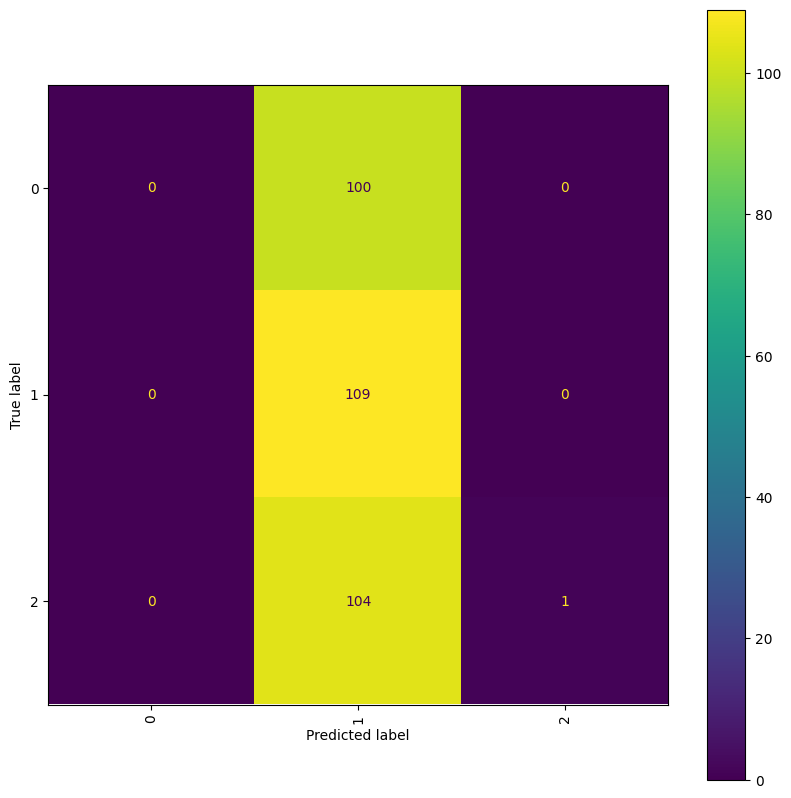

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    actual_value,
    predicted_value,
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)

In [26]:
a= model(eval_dataset.__getitem__(100)['image'].to(DEVICE).unsqueeze(0))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
a.argmax()

In [ ]:
eval_dataset.__getitem__(100)['label'].argmax()

In [ ]:
for each thing in test set

make set of answers/predictions
copare witb kaves